# Preparing stuff

In [51]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from collections import OrderedDict
import ast
import Bio.PDB
from Bio import SeqIO
from IPython.display import display
from collections import Counter 
%matplotlib inline
%run 'functions_dump.py'
notebook_prefix = 'ks01'
image_counter = Counter()

In [45]:
segment_colors = {'S1':'#00aba9', 'S2':'#ff0097', 'S3':'#a200ff', 'S4':'#b8d000', 'S5':'#1ba1e2', 'S6':'#f09609', 
          'S7':'#edc951', 'S8':'#cc2a36', 'S9':'#4f372d', 'S10':'#0c457d', 'S11':'#616161', 'S12':'#800080'}

### Orienting myself

In [20]:
karen_folder = os.getcwd()
analysis_folder = os.path.dirname(os.getcwd())
root_folder = os.path.dirname(analysis_folder)
data_folder = os.path.join(root_folder, 'Data')
figures_folder = os.path.join(karen_folder, 'figures')
small_tables_folder = os.path.join(root_folder, 'Data_Small_Tables')
files_dump_folder = os.path.join(karen_folder, 'files_dump')
structure_predictions_folder = os.path.join(files_dump_folder, 'structure_predictions')

### Reading the data

In [21]:
data_all = OrderedDict()
files = [f for f in os.listdir(data_folder) if '.csv' in f]
for f in sorted(files, key = lambda s: int(s.split('_')[0][1:])):
    data_all[f[:-9]] = pd.read_table(os.path.join(data_folder, f))

### Working with positions

In [22]:
def remove_gaps(seq):
    return ''.join([c for c in seq if c != '-'])

def get_wt_position(position_in_alignment):
    truncated_seq = remove_gaps(aligned_Scer[:position_in_alignment+1])
    return len(truncated_seq)

In [23]:
Scer_Uniprot = open(os.path.join(files_dump_folder, 'HIS3_saccharomyces_cerevisiae_from_Uniprot_P06633.txt')).read().rstrip()
alignment_file = os.path.join(small_tables_folder, 'aa_seq.txt')
for seq_record in SeqIO.parse(alignment_file, 'fasta'):
    if seq_record.id == 'Scer':
        aligned_Scer = str(seq_record.seq)
        break
assert remove_gaps(aligned_Scer) == Scer_Uniprot

In [24]:
positions = pd.read_table(os.path.join(small_tables_folder, 'positions.csv'))
positions = positions.set_index('Unnamed: 0').transpose().reset_index()
positions.rename(columns={'index' : 'segment', 'positions':'positions_alignment'}, inplace=True)
positions.reset_index(drop=True, inplace=True)
positions['positions_alignment'] = positions['positions_alignment'].apply(lambda s: ast.literal_eval(s))
positions['positions_Uniprot_P06633'] = positions.positions_alignment.apply(lambda l: [get_wt_position(p) for p in l])
segment_names = positions.segment.values # not explicitly sorted
positions.to_csv(os.path.join(files_dump_folder, 'information_about_segments.csv'), index=False)
positions

Unnamed: 0,segment,wt1,positions_alignment,len1,len2,start1,end1,wt2,start2,end2,start_Scer,end_Scer,positions_Uniprot_P06633
0,S1,EALGAVRGVK,"[140, 141, 142, 143, 144, 145, 146, 147, 148, ...",10,10,140,149,EALSRAVVDL,160,169,106,135,"[106, 107, 108, 109, 110, 111, 112, 113, 114, ..."
1,S2,SNRPYAVVE,"[170, 171, 172, 173, 174, 175, 176, 177, 178, ...",9,9,170,178,LSCEMIPHF,189,197,136,163,"[136, 137, 138, 139, 140, 141, 142, 143, 144, ..."
2,S3,LGLQREKVGD,"[179, 180, 181, 182, 183, 184, 185, 186, 187, ...",10,7,179,188,LESFAEA,198,204,145,170,"[145, 146, 147, 148, 149, 150, 151, 152, 153, ..."
3,S4,SRITLHVDCL,"[205, 206, 207, 208, 209, 210, 211, 212, 213, ...",10,10,205,214,SAFKALAVAI,225,234,171,200,"[171, 172, 173, 174, 175, 176, 177, 178, 179, ..."
4,S5,RGKNDHHRSE,"[215, 216, 217, 218, 219, 220, 221, 222, 223, ...",10,11,215,224,REATSPNGTND,235,251,181,211,"[181, 182, 183, 184, 185, 186, 187, 188, 189, ..."
5,S6,CGIALGQAFK,"[130, 131, 132, 133, 134, 135, 136, 137, 138, ...",10,10,130,139,RFGSGFAPLD,150,159,96,125,"[96, 97, 98, 99, 100, 101, 102, 103, 104, 105,..."
6,S7,IHALAKHSGW,"[100, 101, 102, 103, 104, 105, 106, 107, 108, ...",10,10,100,109,HIDDHHTTED,120,129,66,95,"[66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 86, 8..."
7,S8,HTGIGFLDHM,"[90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 110, ...",10,10,90,99,SLIVECIGDL,110,119,56,85,"[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 76, 7..."
8,S9,PEKEAE,"[66, 67, 68, 73, 74, 75, 82, 83, 84, 85, 86, 8...",6,8,66,75,TQSQVINV,82,89,36,55,"[36, 37, 38, 39, 40, 41, 48, 49, 50, 51, 52, 5..."
9,S10,IEHSIF,"[41, 42, 43, 44, 64, 65, 76, 77, 78, 79, 80, 81]",6,6,41,65,AVAEQA,76,81,30,47,"[30, 31, 32, 33, 34, 35, 42, 43, 44, 45, 46, 47]"


In [25]:
title = 'Positions of segments according to alignment'
plot_better(grid='', height=2)
old_y = 2
for row in positions.iterrows():
    for position in row[1].positions_alignment:
        new_y = np.random.choice([1,2])
        while new_y == old_y:
            new_y = np.random.choice([1,2])
    x = row[1].positions_alignment
    plt.plot(x, [new_y for e in x], '_', lw=3, alpha=0.7, label=row[1].segment)
    plt.text(np.median(x), new_y + 0.3, row[1].segment)
    old_y = new_y
plt.ylim(0,4)
plt.yticks([])
plt.xlabel('Positions according to the aligment')
plt.title(title)
save_image(image_counter, title, figures_folder, notebook_prefix)
plt.close() 

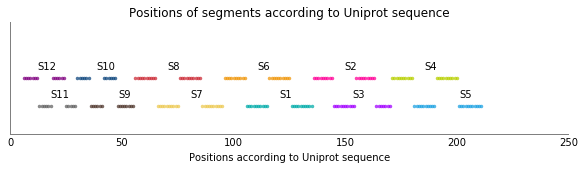

In [58]:
title = 'Positions of segments according to Uniprot sequence'
plot_better(grid='', height=2)
old_y = 2
for row in positions.iterrows():
    for position in row[1].positions_Uniprot_P06633:
        new_y = np.random.choice([1,2])
        while new_y == old_y:
            new_y = np.random.choice([1,2])
    x = row[1].positions_Uniprot_P06633
    plt.plot(x, [new_y for e in x], '.', lw=3, alpha=0.7, label=row[1].segment, color=segment_colors[row[1].segment])
    plt.text(np.median(x), new_y + 0.3, row[1].segment)
    old_y = new_y
plt.ylim(0,4)
plt.yticks([])
plt.xlabel('Positions according to Uniprot sequence')
plt.title(title)
save_image(image_counter, title, figures_folder, notebook_prefix)

In [27]:
title = 'Wild type positions versus alignment positions'
ps = [item for sublist in positions.positions_alignment.values.flatten() for item in sublist]
wt_ps = [get_wt_position(p) for p in ps]

plot_better(height=2.5, grid='')

plt.plot(wt_ps, [1.5 for e in wt_ps], '.')
plt.text(220, 1.48, 'Wild type positions reconstructed from positions_alignment')

plt.plot(range(len(Scer_Uniprot)), [1.2 for e in range(len(Scer_Uniprot))], '.')
plt.text(230, 1.18, 'Positions of the wt sequence from Uniprot')

plt.plot(ps, [1 for e in ps], '.')
plt.text(260, 0.98, 'Positions mentioned in positions.csv')

plt.ylim(0,2)
plt.yticks()
plt.xlim(0, max([max(ps), len(Scer_Uniprot)]))
plt.title(title)
save_image(image_counter, title, figures_folder, notebook_prefix)
plt.close() 

### Keeping only the mutants carrying substitutions (no indels, no mutations in the unmutated "central region")

In [28]:
def count_mutations(muts):
    if not muts > 0:
        return 0
    else:
        return muts.count(':') + 1

In [29]:
data = OrderedDict()
for k,v in data_all.items():
    data[k] = v[(v.middle == 1) & (v.nogap == 1)].copy()
    data[k]['mut_number'] = data[k].mut_list_Scer.apply(count_mutations)

### Unique single mutations

In [30]:
unique_single_mutations = OrderedDict()
for segment_name, segment_data in data.items():
    without_wt = segment_data.dropna(subset=['mut_list_Scer'])
    unique_single_mutations[segment_name] = set(':'.join(without_wt.mut_list_Scer.values).split(':'))
unique_single_mutations['all_segments'] = set().union(*unique_single_mutations.values())
print len(unique_single_mutations['all_segments']), 'unique mutations across all segments'

1891 unique mutations across all segments


### Singles

In [31]:
data_singles = OrderedDict()
known_single_mutations = []
for segment_name, segment_data in data.items():
    data_singles[segment_name] = segment_data[segment_data.mut_list.str.count(':') == 0].copy()
    known_single_mutations += set(':'.join(data_singles[segment_name].mut_list_Scer.values).split(':'))
positions_with_known_mutations = set([int(m[:-1]) for m in known_single_mutations])
print 'There are %s single mutations with known effects. They are found in %s positions' % (len(known_single_mutations),
                                                                                            len(positions_with_known_mutations))

There are 231 single mutations with known effects. They are found in 120 positions


#### A dictionary containing fitness for every known single mutation

In [32]:
single_mut_fitness_dict = {}
for segment_data in data_singles.values():
    single_mut_fitness_dict.update(dict(segment_data[['mut_list_Scer', 's']].values))

### Genotypes consisting of mutations with known effects

In [33]:
def consists_of_known_mutations(mutations, list_of_known_singles):
    for mutation in mutations.split(':'):
        if not mutation in list_of_known_singles:
            return False
    return True

In [34]:
print 'Genotypes consisting of mutations with known effects:'

data_known_mutations_only = OrderedDict()
for segment_name, segment_data in data.items():
    without_wt = segment_data.dropna(subset=['mut_list_Scer']).copy()
    data_known_mutations_only[segment_name] = without_wt[without_wt.mut_list_Scer.apply(
            lambda muts: consists_of_known_mutations(muts, data_singles[segment_name].mut_list_Scer.values))]
    print 'Segment %s: %.2f%% of genotypes (=%s)' %(
        segment_name,
        100. * len(data_known_mutations_only[segment_name]) / len(data[segment_name]),
        len(data_known_mutations_only[segment_name]))

Genotypes consisting of mutations with known effects:
Segment S1_scaled: 95.56% of genotypes (=58146)
Segment S2_scaled: 15.13% of genotypes (=12566)
Segment S3_scaled: 64.52% of genotypes (=44837)
Segment S4_scaled: 55.90% of genotypes (=35769)
Segment S5_scaled: 92.84% of genotypes (=67955)
Segment S6_scaled: 39.40% of genotypes (=25447)
Segment S7_scaled: 85.34% of genotypes (=13815)
Segment S8_scaled: 76.08% of genotypes (=45248)
Segment S9_scaled: 0.23% of genotypes (=189)
Segment S10_scaled: 94.07% of genotypes (=59763)
Segment S11_scaled: 97.43% of genotypes (=33793)
Segment S12_scaled: 15.01% of genotypes (=8685)


### Calculating epistasis

In [35]:
wt_fitness = np.median([table[table.mut_number == 0].s.values[0] for table in data.values()])
min_fitness = np.min([table.s.min() for table in data.values()])
max_fitness = np.max([table.s.max() for table in data.values()])

def mut_effect(fitness):
    return fitness - wt_fitness

min_mut_effect = mut_effect(min_fitness)
max_mut_effect = mut_effect(max_fitness)

def epistasis(single_mut_fitnesses, fitness_of_combination):
    expected_mut_effect = sum([mut_effect(fitness) for fitness in single_mut_fitnesses])
    expected_mut_effect = min(expected_mut_effect, max_mut_effect)
    expected_mut_effect = max(expected_mut_effect, min_mut_effect)
    return mut_effect(fitness_of_combination) - expected_mut_effect

def epistasis_for_df(df):
    mutations_combination = df['mut_list_Scer']
    fitness_of_combination = df['s']
    single_mut_fitnesses = []
    for single_mutation in mutations_combination.split(':'):
        single_mut_fitnesses.append(single_mut_fitness_dict[single_mutation])
    return epistasis(single_mut_fitnesses, fitness_of_combination)

In [36]:
for segment_name, segment_data in data_known_mutations_only.items():
    segment_data['epistasis'] = segment_data.apply(epistasis_for_df, axis=1)

/Users/karen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [52]:
# colors.hex2color('#ffffff')        #==> (1.0, 1.0, 1.0)
# colors.rgb2hex((1.0, 1.0, 1.0))    #==> '#ffffff'
colormap = mpl.cm.Set3
needed = False
if needed:
    for segment in segment_names:
        segment_positions = positions[positions.segment == segment].positions_Uniprot_P06633.values[0]
        get_pymol_script_to_color_positions(segment_positions, colormap=colormap, constant_color=segment_colors[segment])
        
# convert -delay 10 -loop 0 *.png gfp_with_mutations_10.gif

#106
set_color mCol106 = (0.0, 0.6705882352941176, 0.6627450980392157)
select mSel106, resi 106
show spheres, mSel106
color mCol106 ,mSel106
#107
set_color mCol107 = (0.0, 0.6705882352941176, 0.6627450980392157)
select mSel107, resi 107
show spheres, mSel107
color mCol107 ,mSel107
#108
set_color mCol108 = (0.0, 0.6705882352941176, 0.6627450980392157)
select mSel108, resi 108
show spheres, mSel108
color mCol108 ,mSel108
#109
set_color mCol109 = (0.0, 0.6705882352941176, 0.6627450980392157)
select mSel109, resi 109
show spheres, mSel109
color mCol109 ,mSel109
#110
set_color mCol110 = (0.0, 0.6705882352941176, 0.6627450980392157)
select mSel110, resi 110
show spheres, mSel110
color mCol110 ,mSel110
#111
set_color mCol111 = (0.0, 0.6705882352941176, 0.6627450980392157)
select mSel111, resi 111
show spheres, mSel111
color mCol111 ,mSel111
#112
set_color mCol112 = (0.0, 0.6705882352941176, 0.6627450980392157)
select mSel112, resi 112
show spheres, mSel112
color mCol112 ,mSel112
#113
set_colo